<a href="https://colab.research.google.com/github/poliduckie/ReinforcementLearning/blob/main/duckietown_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Test image filters

In [11]:
import os 
if not os.path.isdir('gym-duckietown') or os.path.isdir('../gym-duckietown'):
  branch = "master" #@param ['master', 'daffy']
  !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
  !pip3 install -e gym-duckietown
if os.getcwd() != "/gym-duckietown":
  os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

fatal: destination path 'gym-duckietown' already exists and is not an empty directory.
Obtaining file:///content/gym-duckietown/gym-duckietown
  Attempting uninstall: gym-duckietown
    Found existing installation: gym-duckietown 2019.0.0
    Can't uninstall 'gym-duckietown'. No files were found to uninstall.
  Running setup.py develop for gym-duckietown
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [12]:
plt.rcParams['figure.figsize'] = [20, 10]

In [13]:
map_name = "Duckietown-small_loop-v0" #@param ['Duckietown-straight_road-v0','Duckietown-4way-v0','Duckietown-udem1-v0','Duckietown-small_loop-v0','Duckietown-small_loop_cw-v0','Duckietown-zigzag_dists-v0','Duckietown-loop_obstacles-v0','Duckietown-loop_pedestrians-v0']

In [14]:
import cv2
import gym
from gym.spaces import Box

cutted_img_height = 350
resize_ratio = 0.5

img_height = 480
top_crop = img_height - cutted_img_height

img_final_height = int(cutted_img_height * resize_ratio)
img_final_width = int(640 * resize_ratio)

def cropimg(img):
    """
    Crop top of image top_crop px, they are noise most of the time

    :param img: (RGB image as np array) Image to be cropped
    """
    return img[top_crop:,:]

def houghtransform(img):
    """
    Apply Hough Line transform, for theory see:
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

    :param img: (RGB image as np array)
    """
    frame_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY, 3)
    edges = cv2.Canny(frame_BGR,50,150,apertureSize = 3)
    #minLineLength = 100
    #maxLineGap = 10
    #lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    #for x1,y1,x2,y2 in lines[0]:
    #    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    imgRGB = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
    return imgRGB

def resizeimg(img, ratio):
    """
    Resize image
    :param img: (np array)
    :param ratio: (float) 0<ratio<1
    """
    return cv2.resize(img, (0,0), fx=ratio, fy=ratio) 
  
def takeyellow(img):
    """
    Extract yellow lines, for color ranges see:
    https://stackoverflow.com/questions/48109650/how-to-detect-two-different-colors-using-cv2-inrange-in-python-opencv

    :param img: (RGB image as np array)
    """
    frame_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    frame_threshold = cv2.inRange(frame_HSV, (20,100,100), (50, 255, 255))
    imgRGB = cv2.cvtColor(frame_threshold, cv2.COLOR_GRAY2RGB)
    return imgRGB

def takewhiteyellow(img):
    """
    Extract white and yellow lines

    :param img: (RGB image as np array)
    """
    #white
    sensitivity = 100
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    frame_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    maskwhite = cv2.inRange(frame_HSV, lower_white, upper_white)
    img[maskwhite > 0] = (255, 0, 0)
    img[maskwhite == 0] = (0,0,0)
    #yellow
    maskyellow = cv2.inRange(frame_HSV, (15,70,70), (50, 255, 255))
    img[maskyellow > 0] = (0, 255, 0)
    return img

def white_balance(img):
    """
    Grayworld assumption:
    https://stackoverflow.com/questions/46390779/automatic-white-balancing-with-grayworld-assumption/46391574

    :param img: (RGB image as np array)
    """
    result = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result

class ObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(ObsWrapper, self).__init__(env)
        self.observation_space = Box(0, 255, (img_final_height, img_final_width, 3), dtype=self.observation_space.dtype)
        self.accept_start_angle_deg = 4
        self.env = env

    def observation(self, obs):
        cropped = cropimg(obs)
        resized = resizeimg(cropped, resize_ratio)
        balanced = white_balance(resized)
        img = takewhiteyellow(balanced)
        return img

In [15]:
class BasicWrapper(gym.Wrapper):
    def __init__(self, env):
        super(BasicWrapper, self).__init__(env)
        self.env = env

    def reset(self):
        obs = self.env.reset()
        cropped = cropimg(obs)
        resized = resizeimg(cropped, resize_ratio)
        balanced = white_balance(resized)
        img = takewhiteyellow(balanced)
        while not (img[:,:,1] == 255).any():
            print("Spinning")
            obs, reward, done, info = self.env.step([0, -1])
        return obs

In [16]:
import gym, gym_duckietown

display = Display(visible=0, size=(1400, 900))
display.start()

env = gym.make(map_name)
env = BasicWrapper(env)
env = ObsWrapper(env)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [17]:
obs = env.reset()

In [18]:
(obs[:,:,1] == 255).any()

True

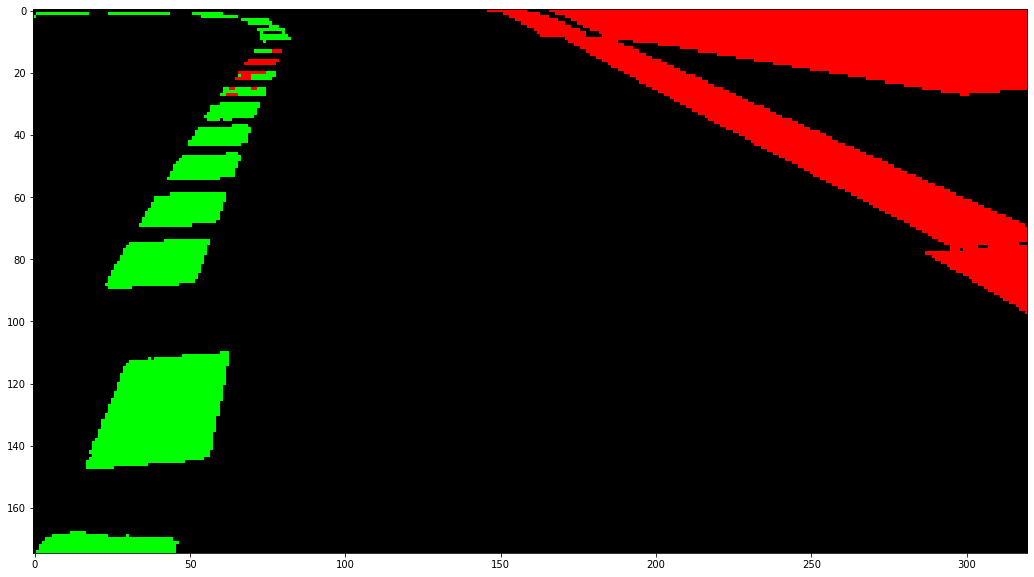

In [19]:
plt.imshow(obs)

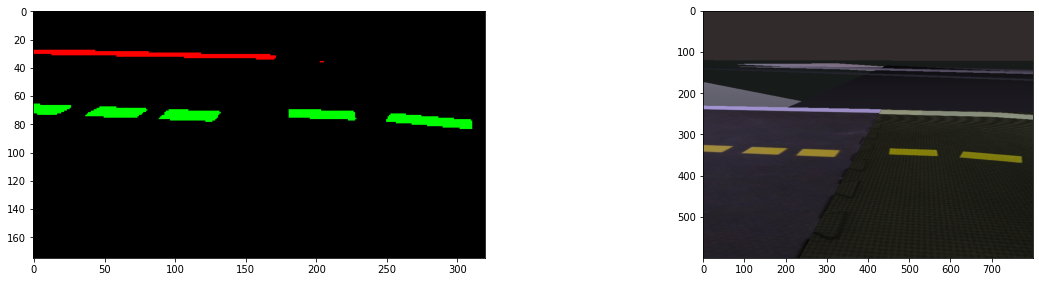

In [20]:
env.reset()

for i in range(10):

    lane_pose = env.get_lane_pos2(env.cur_pos, env.cur_angle)
    distance_to_road_center = lane_pose.dist
    angle_from_straight_in_rads = lane_pose.angle_rad
    
    k_p = 10
    k_d = 1
    speed = 0.5 
    steering = k_p*distance_to_road_center + k_d*angle_from_straight_in_rads
    
    obs, reward, done, info = env.step([speed, steering])
    plt.subplot(2, 2, 1)
    plt.imshow(obs)
    plt.subplot(2, 2, 2)
    plt.imshow(env.render(mode="rgb_array"))
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
        break
ipythondisplay.clear_output(wait=True)